# Gaps on structure functions: **interactive pipeline demo**
1. ~~Email Marcus~~
1. ~~Get heatmap importing and exporting~~
2. MAPE in error trend line plots?
7. Figure out train-test split, noting different stages of having errors in the respective dataframes
8. Thinking about splitting and reducing of data, turn into scripts with parallel capability.
1. Re-run: Here, demo training and testing on one file (still exporting and importing files and heatmap).
2. Get sample-size plot
1. Get plots to save
4. Finalise relational database 
2. Then, in a separate script, start loop over multiple files. Run in chunks first.
7. Add smoothing?
9. Quick scaling study on NeSI, investigating bad ints
10. Results for 1 year of PSP, 1 month of Wind
10. Up the ante to two years, while writing up existing results.


# 1. Download files

Run in terminal

In [1]:
# For selecting a range of dates

# wget --no-clobber --directory-prefix=data/raw/psp  https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2018/psp_fld_l2_mag_rtn_20181102{00..12}_v02.cdf
# wget --no-clobber --directory-prefix=data/raw/wind/ https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h2/2016/wi_h2_mfi_201601{01..07}_v05.cdf

# For entire folders

# wget --no-clobber --directory-prefix=data/raw/psp --recursive -np -nv -nH --cut-dirs=7 --accept cdf  https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2018/
# wget --no-clobber --directory-prefix=data/raw/wind --recursive -np -nv -nH --cut-dirs=2 --accept cdf  https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h2/

# 2. FOR ALL SETS: process individual files

This will be distributed across job arrays on an HPC

## 2a. Import dependencies

In [2]:
import pickle
import pandas as pd
import numpy as np
import ts_dashboard_utils as ts
import src.utils as utils  # copied directly from Reynolds project, normalize() added
import src.params as params
import src.sf_funcs as sf
import sys
import src.data_import_funcs as dif
import json
import glob
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", font_scale=1.5)
#plt.rcParams.update({"font.size": 16})
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec

In [3]:
# For current Wind importing

sys_arg_dict = {
    # arg1
    "mag_path": params.mag_path,
    "proton_path": params.proton_path,
    "electron_path": params.electron_path,
    # arg2
    "mag_vars": [params.timestamp, params.Bwind, params.Bwind_vec],
    "proton_vars": [params.timestamp, params.np, params.Tp],
    "electron_vars": [params.timestamp, params.ne, params.Te],
    # arg3
    "mag_thresh": params.mag_thresh,
    "proton_thresh": params.proton_thresh,
    "electron_thresh": params.electron_thresh,
    # arg4
    "dt_hr": params.dt_hr,
    "int_size": params.int_size,
    # arg5
    "dt_lr": params.dt_lr,
}

## 2b. Read in data and split into standardised intervals

Previously each core read in multiple files at a time. I think it will be better for each core to do one file at a time, especially given that each raw file contains sufficient *approximate* correlation lengths for us to then calculate the *local* outer scale and create our standardise intervals using that.

#### PSP data

In [4]:
raw_file_list = sorted(glob.iglob(f"data/raw/psp/" + "/*.cdf"))
raw_file_list

['data/raw/psp\\psp_fld_l2_mag_rtn_2018110200_v02.cdf',
 'data/raw/psp\\psp_fld_l2_mag_rtn_2018110206_v02.cdf',
 'data/raw/psp\\psp_fld_l2_mag_rtn_2018110212_v02.cdf']

In [5]:
# Selecting one file to read in
file_index = 2

In [6]:
# psp_data = dif.read_cdfs(
#     [raw_file_list[file_index]],  # LIMIT HERE!
#     {"epoch_mag_RTN": (0), "psp_fld_l2_mag_RTN": (0, 3), "label_RTN": (0, 3)},
# )
# psp_data_ready = dif.extract_components(
#     psp_data,
#     var_name="psp_fld_l2_mag_RTN",
#     label_name="label_RTN",
#     time_var="epoch_mag_RTN",
#     dim=3,
# )
# psp_df = pd.DataFrame(psp_data_ready)
# psp_df["Time"] = pd.to_datetime("2000-01-01 12:00") + pd.to_timedelta(
#     psp_df["epoch_mag_RTN"], unit="ns"
# )
# psp_df = psp_df.drop(columns="epoch_mag_RTN").set_index("Time")

# df_raw = psp_df["B_R"]
# print("\n")
# print(df_raw.info())

# del psp_data, psp_data_ready, psp_df

#### Wind data

In [7]:
raw_file_list = sorted(glob.iglob(f"data/raw/wind/" + "/*.cdf"))
raw_file_list

['data/raw/wind\\wi_h2_mfi_20160101_v05.cdf',
 'data/raw/wind\\wi_h2_mfi_20160102_v05.cdf',
 'data/raw/wind\\wi_h2_mfi_20160103_v05.cdf',
 'data/raw/wind\\wi_h2_mfi_20160104_v05.cdf',
 'data/raw/wind\\wi_h2_mfi_20160105_v05.cdf',
 'data/raw/wind\\wi_h2_mfi_20160106_v05.cdf',
 'data/raw/wind\\wi_h2_mfi_20160107_v05.cdf']

Not currently running (takes a while due to large files)

In [8]:
df = utils.pipeline(
    raw_file_list[file_index],
    varlist=sys_arg_dict["mag_vars"],
    thresholds=sys_arg_dict["mag_thresh"],
    cadence=sys_arg_dict["dt_hr"],
)

print("Reading {0}: {1:.1f}% missing".format(raw_file_list[0], df.iloc[:,0].isna().sum()/len(df)*100))

# Ensuring observations are in chronological order
df_wind_hr = df.sort_index()

# df_wind_hr = pd.read_pickle("data/processed/" + params.mag_path + params.dt_hr + ".pkl")
df_wind_hr = df_wind_hr.rename(
    columns={
        params.Bwind: "Bwind",
        params.Bx: "Bx",
        params.By: "By",
        params.Bz: "Bz",
    }
)

missing = df_wind_hr.iloc[:, 0].isna().sum() / len(df_wind_hr)

if missing > 0.4:
    # Replacing values in lists with na
    print("Large missing %")
else:
    int_wind_hr = df_wind_hr.interpolate().ffill().bfill()

df_raw = int_wind_hr["Bx"]

print(df_raw.info())

Reading data/raw/wind\wi_h2_mfi_20160101_v05.cdf: 2.2% missing
<class 'pandas.core.series.Series'>
DatetimeIndex: 939130 entries, 2016-01-03 00:00:00 to 2016-01-03 23:59:59.868000
Freq: 92L
Series name: Bx
Non-Null Count   Dtype  
--------------   -----  
939130 non-null  float32
dtypes: float32(1)
memory usage: 10.7 MB
None


The following chunk gives some metadata - not necessary for the pipeline

In [9]:
### 0PTIONAL CODE ###

if df_raw.isnull().sum() == 0:
    print("No missing data")
else:
    print(f"{df_raw.isnull().sum()} missing points")
print("Length of interval: " + str(df_raw.notnull().sum()))
print("Duration of interval: " + str(df_raw.index[-1] - df_raw.index[0]))
x = df_raw.values

# Frequency of measurements
print("Duration between some adjacent data points:")
print(df_raw.index[2] - df_raw.index[1])
print(df_raw.idx[3] - df_raw.index[2])
print(df_raw.index[4] - df_raw.index[3])

a = df_raw.index[2] - df_raw.index[1]
x_freq = 1 / (a.microseconds / 1e6)
print("\nFrequency is {0:.1f} Hz (2dp)".format(x_freq))

print("Mean = {}".format(np.mean(x)))
print("Standard deviation = {}\n".format(np.std(x)))

### 0PTIONAL CODE END ###

No missing data
Length of interval: 939130
Duration of interval: 0 days 23:59:59.868000
Duration between some adjacent data points:
0 days 00:00:00.092000


AttributeError: 'Series' object has no attribute 'idx'

In [35]:
times_to_gap = 2

In [ ]:
tc_approx = 2000  # s: 500 for PSP, 2000 for Wind
cadence_approx = 1  # s: 0.1 for PSP, 1 for Wind

tc_n = 10  # Number of actual (computed) correlation times we want in our standardised interval...
interval_length = 10000  # ...across this many points

df = df_raw.resample(str(cadence_approx) + "S").mean()

ints = []
tc_list = []
cadence_list = []

time_lags_lr, r_vec_lr = utils.compute_nd_acf(
    [df],
    nlags=30000, # 100000 for PSP, 30000 for Wind
    plot=False,
)

tc = utils.compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, plot=False)

if tc == -1:
    tc = tc_approx
    new_cadence = tc_n * tc / interval_length
    print(
        f"tc not found for this interval, setting to 500s (default) -> cadence = {new_cadence}s"
    )

else:
    new_cadence = tc_n * tc / interval_length
    print(
        f"Using the 1/e trick, tc was calculated to be {np.round(tc,2)}s -> data resampled to new cadence of {np.round(new_cadence,2)}s, for {tc_n}tc across {interval_length} points"
    )

tc_list.append(tc)
cadence_list.append(new_cadence)

try:
    interval_approx_resampled = df.resample(
        str(np.round(new_cadence, 3)) + "S"
    ).mean()  # Resample to higher frequency

    for i in range(
        0, len(interval_approx_resampled) - interval_length + 1, interval_length
    ):
        interval = interval_approx_resampled.iloc[i : i + interval_length]
        # Check if interval is complete
        if interval.isnull().sum()/len(interval) < 0.01:
            # Linear interpolate
            interval = interval.interpolate(method="linear")
            int_norm = utils.normalize(interval)
            ints.append(int_norm)
        else:
            print("Too many NaNs in interval, skipping")


except Exception as e:
    print(f"An error occurred: {e}")

print(
    "Given this correlation length, this file yields",
    len(ints),
    "standardised interval/s")
if len(ints) > 0:
    print("These will be now decimated in",
    times_to_gap,
    "different ways")
else:
    print("NO GOOD INTERVALS WITH GIVEN SPECIFICATIONS")

Using the 1/e trick, tc was calculated to be 7417.69s -> data resampled to new cadence of 7.42s, for 10tc across 10000 points
Given this correlation length, this file yields 1 standardised interval/s
These will be now decimated in 2 different ways


In [ ]:
# Delete original dataframes
del df_raw

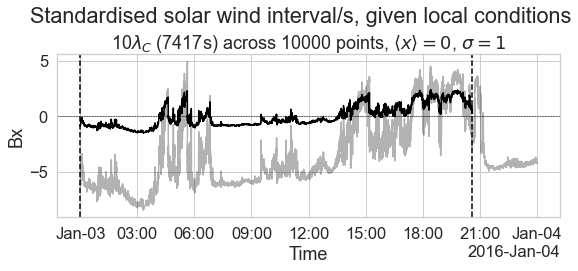

In [ ]:
fig, ax = plt.subplots(figsize=(9, 3))
plt.plot(df, alpha=0.3, c="black")
plt.axvline(df.index[0], c="black", linestyle="dashed")
[
    plt.axvline(interval.index[-1], c="black", linestyle="dashed")
    for interval in ints
]
[plt.plot(interval, c="black") for interval in ints]
plt.axhline(0, c="black", linewidth=0.5, linestyle="--")
plt.suptitle(
    f"Standardised solar wind interval/s, given local conditions" , y= 1.1)
# Add subtitle
plt.title(f"{tc_n}$\lambda_C$ ({int(tc)}s) across {interval_length} points, $\langle x \\rangle=0$, $\sigma=1$")

# ax.set_xlim(interval_list_approx[0].index[0], interval_list_approx[2].index[-1])
ax.set_xlabel("Time")
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_ylabel(f"{interval.name}")

output_file_path = raw_file_list[file_index].replace("data/raw", "plots/temp").replace(".cdf", "_ints.png")
plt.savefig(output_file_path, bbox_inches='tight')

In [ ]:
raw_ints_meta = pd.DataFrame({
    "file_index": file_index,
    "raw_int_start": df.index[0],
    "raw_int_end": df.index[-1],
    "tc": tc_list,
    "cadence": cadence_list,
})
raw_ints_meta

,file_index,raw_int_start,raw_int_end,tc,cadence
0,2,2016-01-03,2016-01-03 23:59:59,7417.694,7.417694


In [ ]:
ints_meta = pd.DataFrame({
    "file_index": file_index,
    "int_start": [interval.index[0] for interval in ints],
    "int_end": [interval.index[-1] for interval in ints],
})
ints_meta.reset_index(inplace=True)
ints_meta.rename(columns={"index": "int_index"}, inplace=True)
ints_meta

,int_index,file_index,int_start,int_end
0,0,2,2016-01-03,2016-01-03 20:36:12.582


## 2c. Calculate the true SF and slope for each interval

In [ ]:
lags = np.arange(1, 0.1 * len(ints[0]))

# Logarithmically-spaced lags?
# vals = np.logspace(0, 3, 0.25 * len(ints[0]))
# lags = np.unique(vals.astype(int))

powers = [2]

In [ ]:
sfs = pd.DataFrame()

for i, input in enumerate(ints):
    # print(f"\nCore {core} processing standardised interval {i}")
    good_output, slope = sf.compute_sf(pd.DataFrame(input), lags, powers, False, False, [10,100])
    
    good_output.insert(0, "int_index", i)
    sfs = pd.concat([sfs, good_output])
    ints_meta.loc[ints_meta["int_index"]==i, "slope"] = slope

sfs.head()

,int_index,lag,n,missing_percent,sf_2,sf_2_se
1.0,0,1.0,9999,0.0,0.007666,0.000472
2.0,0,2.0,9998,0.0,0.016540,0.001051
3.0,0,3.0,9997,0.0,0.023697,0.001421
4.0,0,4.0,9996,0.0,0.029495,0.001586
5.0,0,5.0,9995,0.0,0.034591,0.001678


Text(0.5, 1.0, 'Original $S_2(\\tau)$ for interval beginning 2016-01-03 00:00:00')

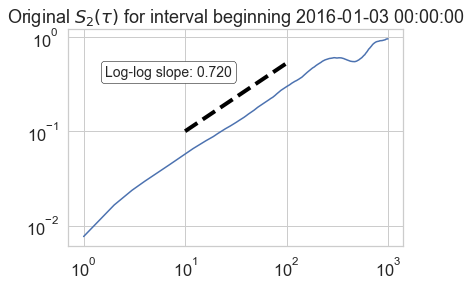

In [ ]:
check_int = 0
slope = ints_meta.loc[ints_meta["int_index"]==check_int, "slope"].values[0]
timestamp = ints_meta.loc[ints_meta["int_index"]==check_int, "int_start"][0]

from src.data_import_funcs import pltpwrl
plt.plot(sfs.loc[sfs["int_index"]==check_int, "lag"], sfs.loc[sfs["int_index"]==check_int, "sf_2"])
pltpwrl(10,0.1, 10, 100, slope, lw=4, ls="--", color="black")
# Annotate with slope
plt.annotate(
    f"Log-log slope: {slope:.3f}",
    xy=(0.3, 0.8),
    xycoords="axes fraction",
    ha="center",
    va="center",
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5),
    fontsize=14
)
plt.semilogx()
plt.semilogy()
plt.title(f"Original $S_2(\\tau)$ for interval beginning {timestamp}")


## 2d. Duplicate, gap, interpolate, analyse intervals
Gap in $x$ different ways, then calculate SF and corresponding slope for gappy (naive) and interpolated (lint) versions of each of these duplicate intervals.

In [ ]:
minimum_missing_chunks = 0.7
np.random.seed(123) # For reproducibility

In [ ]:
index_list = []
version_list = []
handling_list = []
missing_list = []
slopes_list = []

sfs_copies = pd.DataFrame()
ints_copies = pd.DataFrame()

for index in range(len(ints)):
    input = ints[index]

    for j in range(times_to_gap):
        total_removal = np.random.uniform(0, 0.95)
        ratio_removal = np.random.uniform(minimum_missing_chunks, 1)
        # print("Nominal total removal: {0:.1f}%".format(total_removal * 100))
        # print("Nominal ratio: {0:.1f}%".format(ratio_removal * 100))
        prop_remove_chunks = total_removal * ratio_removal
        prop_remove_unif = total_removal * (1 - ratio_removal)
        bad_input_temp, bad_input_ind, prop_removed = ts.remove_data(
            input, prop_remove_chunks, chunks=np.random.randint(1, 10)
        )
        bad_input, bad_input_ind, prop_removed = ts.remove_data(
            bad_input_temp, prop_remove_unif
        )
        if prop_removed >= 0.95 or prop_removed == 0:
            # print(">95% or 0% data removed, skipping")
            continue

        bad_output, slope = sf.compute_sf(pd.DataFrame(bad_input), lags, powers, False, False, [10,100])
        bad_output["int_index"] = index
        bad_output["version"] = j
        bad_output["gap_handling"] = "naive"
        sfs_copies = pd.concat([sfs_copies, bad_output])

        for handling in ["naive", "lint"]:
            index_list.append(index)
            version_list.append(j)
            missing_list.append(prop_removed*100)
            handling_list.append(handling)

            if handling == "naive":
                slopes_list.append(slope)
                # Once we are done with computing the SF, add some metadata to the interval
                bad_input_df = pd.DataFrame(bad_input)
                bad_input_df.reset_index(inplace=True)
                bad_input_df["int_index"] = index
                bad_input_df["version"] = j
                bad_input_df["gap_handling"] = handling
                ints_copies = pd.concat([ints_copies, bad_input_df])

            elif handling == "lint":
                interp_input = bad_input.interpolate(method="linear")
                interp_output, slope = sf.compute_sf(pd.DataFrame(interp_input), lags, powers, False, False, [10,100])
                slopes_list.append(slope)
                
                # # Once we are done with computing the SF, add some metadata to the interval
                interp_input_df = pd.DataFrame(interp_input)
                interp_input_df.reset_index(inplace=True)
                interp_input_df["int_index"] = index
                interp_input_df["version"] = j
                interp_input_df["gap_handling"] = handling
                ints_copies = pd.concat([ints_copies, interp_input_df])

                interp_output["int_index"] = index
                interp_output["version"] = j
                interp_output["gap_handling"] = handling
                
                # Correcting sample size and uncertainty for linear interpolation, same values as no handling
                interp_output["missing_percent"] = bad_output["missing_percent"]
                interp_output["sf_2_se"] = bad_output["sf_2_se"]

                sfs_copies = pd.concat([sfs_copies, interp_output])

In [ ]:
ints_copies_meta = pd.DataFrame({"int_index": index_list, "version": version_list, "missing_percent_overall": missing_list, "gap_handling": handling_list, "slope": slopes_list})

### 5. Calculate errors relative to true values

Join original and copies dataframes and do column operation

In [ ]:
ints_copies_meta = pd.merge(ints_meta, ints_copies_meta, how="inner", on="int_index", suffixes=("_orig", ""))
ints_copies_meta["slope_pe"] = (ints_copies_meta["slope"] - ints_copies_meta["slope_orig"]) / ints_copies_meta["slope_orig"] * 100
ints_copies_meta["slope_ape"] = np.abs(ints_copies_meta["slope_pe"])

In [ ]:
sfs_copies = pd.merge(sfs, sfs_copies, how="inner", on=["int_index", "lag"], suffixes=("_orig", ""))
sfs_copies["sf_2_pe"] = (sfs_copies["sf_2"] - sfs_copies["sf_2_orig"]) / sfs_copies["sf_2_orig"] * 100

Calculate MAPE for each interval copy

In [ ]:
for i in range(len(ints)):
    for j in range(times_to_gap):
        for gap_handling in ["naive", "lint"]:
            mape = np.mean(np.abs(sfs_copies.loc[(sfs_copies["int_index"]==i) & (sfs_copies["version"]==j) & (sfs_copies["gap_handling"]==gap_handling), "sf_2_pe"]))
            ints_copies_meta.loc[(ints_copies_meta["int_index"]==i) & (ints_copies_meta["version"]==j) & (ints_copies_meta["gap_handling"]==gap_handling), "mape"] = mape

In [ ]:
# Export the dataframes in one big pickle file
output_file_path = raw_file_list[file_index].replace("raw", "processed").replace(".cdf", ".pkl")

with open(output_file_path, "wb") as f:
    pickle.dump(
        {
            "raw_ints_meta": raw_ints_meta,
            "ints_meta": ints_meta,
            "ints": ints,
            "ints_copies_meta": ints_copies_meta,
            "ints_copies": ints_copies,
            "sfs": sfs,
            "sfs_copies": sfs_copies,
        },
        f,
    )

In [12]:
# Load in each pickle file psp_dataframes_0X.pkl and concatenate them
# into one big dataframe for each of the four dataframes

# Get all the pickle files in data/psp/processed
pickle_files = sorted(glob.glob("data/processed/wind/wi_*.pkl"))

# Initialize dictionaries to store concatenated DataFrames
concatenated_dataframes = {
    "raw_ints_meta": [],
    "ints_meta": [],
    "ints": [],
    "ints_copies_meta": [],
    "ints_copies": [],
    "sfs": [],
    "sfs_copies": []
}

# Read each pickle file and concatenate the DataFrames
for file in pickle_files:
    with open(file, "rb") as f:
        data = pickle.load(f)
        for key in concatenated_dataframes.keys():
            concatenated_dataframes[key].append(data[key])

# Concatenate the lists of DataFrames into single DataFrames
for key in concatenated_dataframes.keys():
    if key == "ints": # Ints is a list of list of pd.Series, not a list of dataframes
        concatenated_dataframes[key] = concatenated_dataframes[key]
    else:
        concatenated_dataframes[key] = pd.concat(concatenated_dataframes[key], ignore_index=True)

# Access the concatenated DataFrames
raw_ints_meta = concatenated_dataframes["raw_ints_meta"]
ints_meta = concatenated_dataframes["ints_meta"]
ints = concatenated_dataframes["ints"]
ints_copies_meta = concatenated_dataframes["ints_copies_meta"]
ints_copies = concatenated_dataframes["ints_copies"]
sfs = concatenated_dataframes["sfs"]
sfs_copies = concatenated_dataframes["sfs_copies"]


In [14]:
ints_copies_meta

,int_index,file_index,int_start,int_end,slope_orig,version,missing_percent_overall,gap_handling,slope,slope_pe,slope_ape,mape
0,0,2,2016-01-03,2016-01-03 20:36:12.582,0.720494,0,45.55,naive,0.822932,14.217658,14.217658,6.368892
1,0,2,2016-01-03,2016-01-03 20:36:12.582,0.720494,0,45.55,lint,0.791379,9.838421,9.838421,33.238522
2,0,2,2016-01-03,2016-01-03 20:36:12.582,0.720494,1,55.68,naive,0.685329,-4.880730,4.880730,9.956912
3,0,2,2016-01-03,2016-01-03 20:36:12.582,0.720494,1,55.68,lint,0.673903,-6.466528,6.466528,54.714382


# 3. FOR PSP TRAINING SET: Merge file outputs together, export heatmap
for statistical analysis of errors

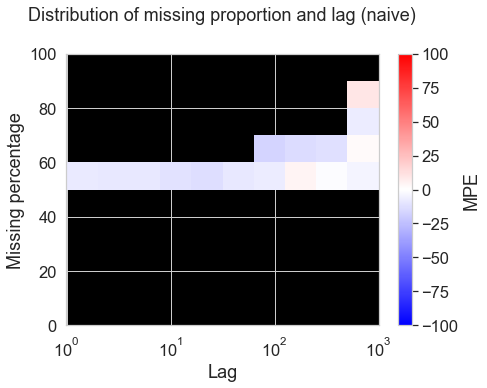

In [44]:
missing_measure = "missing_percent"
n_bins = 10

heatmap_bin_vals_2d_naive, heatmap_bin_edges_2d_naive, lookup_table_2d_naive = (
    sf.create_heatmap_lookup(
        sfs_copies[sfs_copies["gap_handling"]=="naive"], missing_measure, n_bins, log=True
    )
)

fig, ax = plt.subplots(figsize=(7, 5))
plt.pcolormesh(
    heatmap_bin_edges_2d_naive[0],
    heatmap_bin_edges_2d_naive[1],
    heatmap_bin_vals_2d_naive.T,
    cmap="bwr",
)
plt.colorbar(label="MPE")
plt.clim(-100, 100)
plt.xlabel("Lag")
plt.ylabel("Missing percentage")
plt.title("Distribution of missing proportion and lag (naive)", y=1.1)
ax.set_facecolor("black")
ax.set_xscale("log")

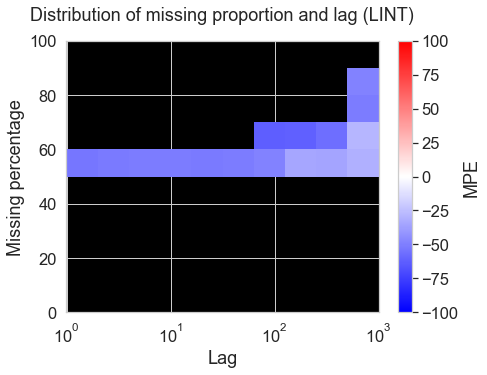

In [16]:
missing_measure = "missing_percent"
n_bins = 10

heatmap_bin_vals_2d, heatmap_bin_edges_2d, lookup_table_2d = (
    sf.create_heatmap_lookup(
        sfs_copies[sfs_copies["gap_handling"]=="lint"], missing_measure, n_bins, log=True
    )
)

fig, ax = plt.subplots(figsize=(7, 5))

plt.pcolormesh(
    heatmap_bin_edges_2d[0],
    heatmap_bin_edges_2d[1],
    heatmap_bin_vals_2d.T,
    cmap="bwr",
)
plt.colorbar(label="MPE")
plt.clim(-100, 100)
plt.xlabel("Lag")
plt.ylabel("Missing percentage")
plt.title("Distribution of missing proportion and lag (LINT)", pad = 20)
ax.set_facecolor("black")
ax.set_xscale("log")

plt.savefig("plots/temp/missing_prop_lag_heatmap_lint.png", bbox_inches='tight')

In [45]:
lookup_table_2d.head()

,Unnamed: 0,lag,missing_percent,mpe,mpe_sd,pe_min,pe_max,scaling,scaling_lower,scaling_upper
0,0,1.487531,55.0,-53.422220,0.438574,-53.860790,-52.983643,2.146946,2.126919,2.167354
1,1,2.977669,55.0,-52.093490,1.997446,-54.204060,-49.410640,2.087399,1.976700,2.183600
2,2,5.950587,55.0,-51.185986,1.373186,-53.428143,-49.245550,2.048592,1.970271,2.147219
3,3,11.881744,55.0,-51.192734,3.514672,-56.955536,-46.520267,2.048875,1.869867,2.323179
4,4,23.714776,55.0,-51.831230,7.028658,-59.260750,-44.212130,2.076034,1.792504,2.454635


In [19]:
heatmap_bin_vals_3d, heatmap_bin_edges_3d, lookup_table_3d = (
    sf.create_heatmap_lookup_3D(
        sfs_copies[sfs_copies["gap_handling"]=="lint"], missing_measure, n_bins, True
    )
)

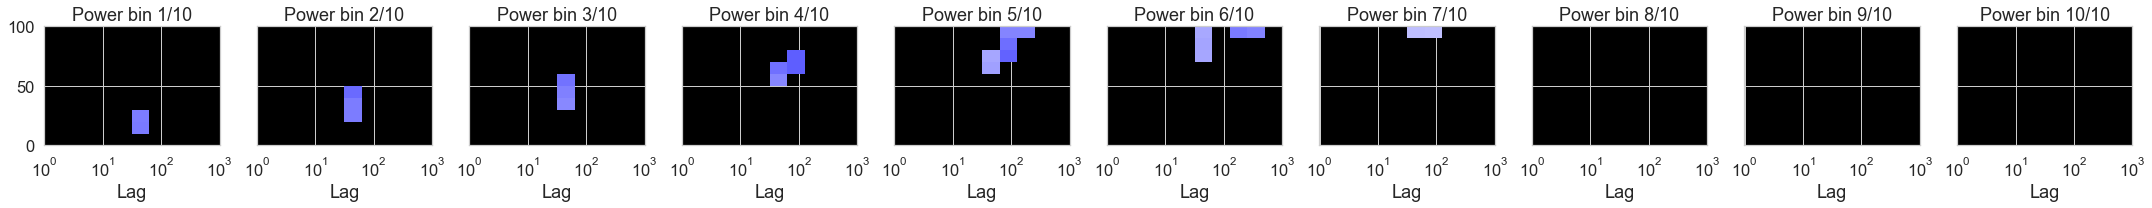

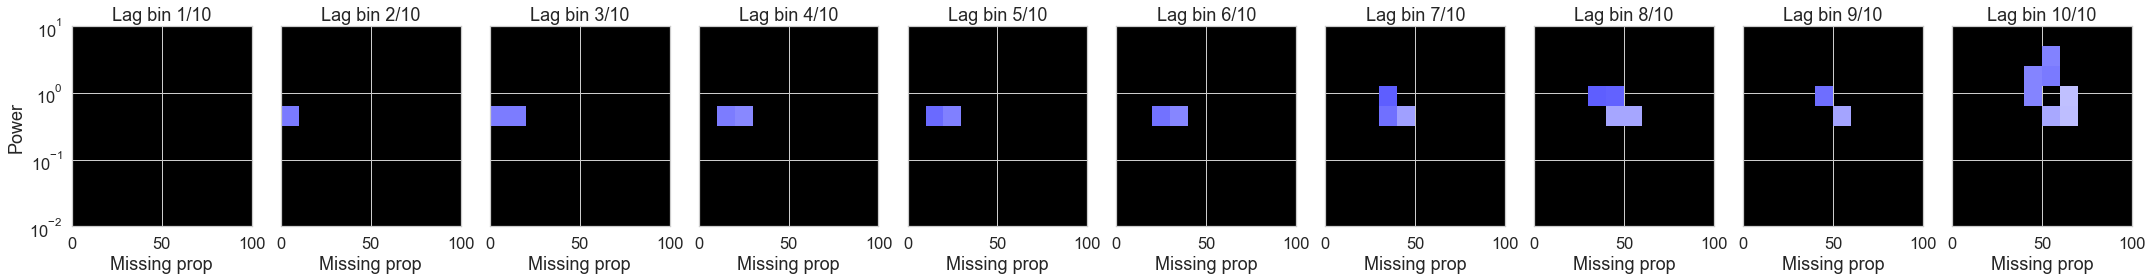

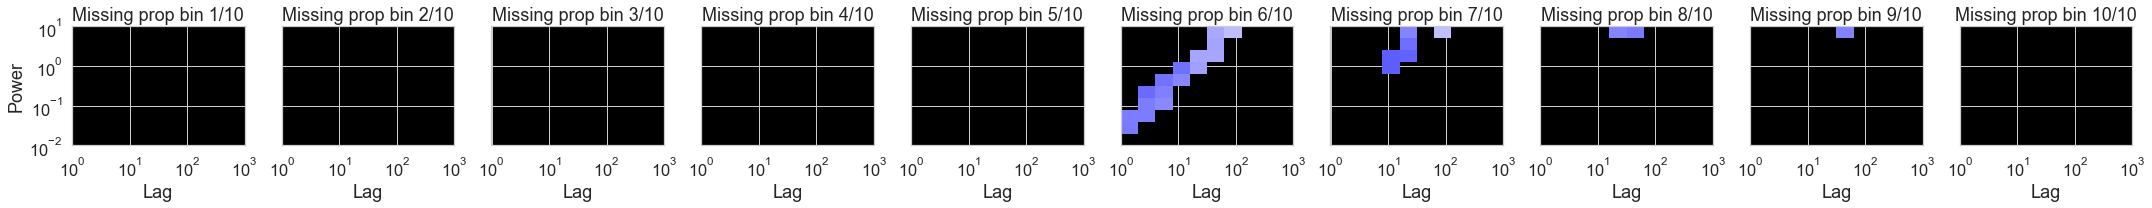

In [20]:
# Plotting 3D heatmaps

fig, ax = plt.subplots(1, n_bins, figsize=(n_bins * 3, 3.5), tight_layout=True)
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.2)
for i in range(n_bins):
    c = ax[i].pcolormesh(
        heatmap_bin_edges_3d[0],
        heatmap_bin_edges_3d[1],
        heatmap_bin_vals_3d[:, :, i],
        cmap="bwr",
    )
    # plt.colorbar(label="MPE")
    c.set_clim(-100, 100)
    plt.xlabel("Lag")
    plt.ylabel("Missing proportion")
    plt.title("Distribution of missing proportion and lag")
    ax[i].set_facecolor("black")
    ax[i].semilogx()
    ax[i].set_title(
        f"Power bin {i+1}/{n_bins}".format(np.round(heatmap_bin_edges_3d[2][i], 2))
    )
    ax[i].set_xlabel("Lag")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        ax[i].set_yticklabels([])
        ax[i].set_ylabel("")
#plt.savefig(save_dir + f"error_heatmap_b_{n_bins}_3d_power.png")
#plt.close()

fig, ax = plt.subplots(1, n_bins, figsize=(n_bins * 3, 3.5), tight_layout=True)
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.2)
for i in range(n_bins):
    c = ax[i].pcolormesh(
        heatmap_bin_edges_3d[1],
        heatmap_bin_edges_3d[2],
        heatmap_bin_vals_3d[i, :, :],
        cmap="bwr",
    )
    # plt.colorbar(label="MPE")
    c.set_clim(-100, 100)
    ax[i].set_xlabel("Missing prop")
    ax[i].set_ylabel("Power")
    plt.title("Distribution of missing proportion and lag")
    ax[i].set_facecolor("black")
    ax[i].semilogy()
    ax[i].set_title(
        f"Lag bin {i+1}/{n_bins}".format(np.round(heatmap_bin_edges_3d[2][i], 2))
    )
    ax[i].set_xlabel("Missing prop")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        ax[i].set_yticklabels([])
        ax[i].set_ylabel("")
#plt.savefig(save_dir + f"error_heatmap_b_{n_bins}_3d_lag.png")
#plt.close()

fig, ax = plt.subplots(1, n_bins, figsize=(n_bins * 3, 3.5), tight_layout=True)
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.2)
for i in range(n_bins):
    c = ax[i].pcolormesh(
        heatmap_bin_edges_3d[0],
        heatmap_bin_edges_3d[2],
        heatmap_bin_vals_3d[:, i, :],
        cmap="bwr",
    )
    # plt.colorbar(label="MPE")
    c.set_clim(-100, 100)
    plt.title("Distribution of missing proportion and lag")
    ax[i].set_facecolor("black")
    ax[i].semilogx()
    ax[i].semilogy()
    ax[i].set_title(
        f"Missing prop bin {i+1}/{n_bins}".format(
            np.round(heatmap_bin_edges_3d[2][i], 2)
        )
    )
    ax[i].set_xlabel("Lag")
    ax[i].set_ylabel("Power")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        ax[i].set_yticklabels([])
        ax[i].set_ylabel("")
#plt.savefig(save_dir + f"error_heatmap_b_{n_bins}_3d_missing.png")
#plt.close()


In [22]:
lookup_table_3d.head()

,lag,missing_percent,sf_2,mpe,mpe_sd,pe_min,pe_max,scaling,scaling_lower,scaling_upper
0,2.977669,55.0,0.014976,-51.614788,2.204147,-53.818935,-49.410641,2.066747,1.976700,2.165390
1,5.950587,55.0,0.014976,-51.229992,1.477840,-53.428143,-49.245548,2.050440,1.970271,2.147219
2,5.950587,55.0,0.029882,-51.053959,0.983505,-52.037464,-50.070454,2.043066,2.002822,2.084961
3,11.881744,55.0,0.029882,-51.504230,3.409392,-56.955536,-46.704422,2.062036,1.876328,2.323179
4,11.881744,55.0,0.059622,-46.520267,0.000000,-46.520267,-46.520267,1.869867,1.869867,1.869867


In [23]:
# Export the lookup table as a CSV
print("Exporting lookup tables to CSV")
lookup_table_2d.to_csv("data/processed/lookup_table_2d_b_{n_bins}.csv")
lookup_table_3d.to_csv("data/processed/lookup_table_3d_b_{n_bins}.csv")

Exporting lookup tables to CSV


# 4. FOR ALL TEST SETS: Import heatmap, correct test sets

In [50]:
# Importing lookup table
lookup_table_2d = pd.read_csv("data/processed/lookup_table_2d_b_{n_bins}.csv", index_col=0)
lookup_table_3d = pd.read_csv("data/processed/lookup_table_3d_b_{n_bins}.csv", index_col=0)

In [47]:
lookup_table_2d

,Unnamed: 0,lag,missing_percent,mpe,mpe_sd,pe_min,pe_max,scaling,scaling_lower,scaling_upper
0,0,1.487531,55.0,-53.422220,0.438574,-53.860790,-52.983643,2.146946,2.126919,2.167354
1,1,2.977669,55.0,-52.093490,1.997446,-54.204060,-49.410640,2.087399,1.976700,2.183600
2,2,5.950587,55.0,-51.185986,1.373186,-53.428143,-49.245550,2.048592,1.970271,2.147219
3,3,11.881744,55.0,-51.192734,3.514672,-56.955536,-46.520267,2.048875,1.869867,2.323179
4,4,23.714776,55.0,-51.831230,7.028658,-59.260750,-44.212130,2.076034,1.792504,2.454635
5,5,47.322415,55.0,-50.902440,7.139003,-59.099560,-42.834583,2.036761,1.749309,2.444961
6,6,94.421136,55.0,-49.178880,11.296680,-62.837560,-35.992767,1.967686,1.562323,2.690889
7,7,94.421136,65.0,-62.849026,0.005388,-62.854225,-62.838980,2.691720,2.690992,2.692096
8,8,188.386038,55.0,-34.993496,0.628052,-35.962870,-33.829980,1.538307,1.511258,1.561594
9,9,188.386038,65.0,-61.969360,0.663747,-63.018192,-60.860626,2.629459,2.554972,2.704032


In [25]:
# Apply 2D and 3D scaling to test set, report avg errors
print(f"Correcting interpolated test set intervals using 2D error heatmap with {n_bins} bins")
sfs_copies_corrected = sf.compute_scaling(
    sfs_copies[sfs_copies["gap_handling"]=="lint"], missing_measure, lookup_table_2d
)

Correcting interpolated test set intervals using 2D error heatmap with 10 bins


In [26]:
print(f"Correcting interpolated test set intervals using 3D error heatmap with {n_bins} bins")
sfs_copies_corrected = sf.compute_scaling_3d(
    sfs_copies_corrected[sfs_copies_corrected["gap_handling"]=="lint"], missing_measure, lookup_table_3d
)

Correcting interpolated test set intervals using 3D error heatmap with 10 bins


In [27]:
correction_wide =  sfs_copies_corrected[["int_index", "version", "lag", "missing_percent", "sf_2_corrected_2d", "sf_2_corrected_3d"]]
correction_long = pd.wide_to_long(correction_wide, ["sf_2"], i=["int_index", "version", "lag", "missing_percent"], j="gap_handling", sep="_", suffix=r"\w+")
correction_bounds_wide =  sfs_copies_corrected[["int_index", "version", "lag", "missing_percent", "sf_2_lower_corrected_2d", "sf_2_lower_corrected_3d", "sf_2_upper_corrected_2d", "sf_2_upper_corrected_3d"]]
correction_bounds_long = pd.wide_to_long(correction_bounds_wide, ["sf_2_lower", "sf_2_upper"], i=["int_index", "version", "lag", "missing_percent"], j="gap_handling", sep="_", suffix=r"\w+")

corrections_long = pd.merge(correction_long, correction_bounds_long, how="inner", on=["int_index", "version", "lag", "missing_percent", "gap_handling"]).reset_index()

In [28]:
# Removing the error columns: note that these might not actually be present at this stage in the test set

sfs_copies_small = sfs_copies[["int_index", "version", "missing_percent", "gap_handling", "lag", "sf_2"]]
sfs_copies_small = pd.concat([sfs_copies_small, corrections_long])
sfs_copies_small = pd.merge(sfs, sfs_copies_small, how="inner", on=["int_index", "lag"], suffixes=("_orig", ""))

In [29]:
sfs_copies_small

,int_index,lag,n,missing_percent_orig,sf_2_orig,sf_2_se,version,missing_percent,gap_handling,sf_2,sf_2_lower,sf_2_upper
0,0,1.0,9999,0.0,0.007666,0.000472,0,53.275328,naive,0.005909,NaN,NaN
1,0,1.0,9999,0.0,0.007666,0.000472,0,53.275328,lint,0.003537,NaN,NaN
2,0,1.0,9999,0.0,0.007666,0.000472,1,57.235724,naive,0.008149,NaN,NaN
3,0,1.0,9999,0.0,0.007666,0.000472,1,57.235724,lint,0.003604,NaN,NaN
4,0,1.0,9999,0.0,0.007666,0.000472,0,53.275328,corrected_2d,0.007593,0.007523,0.007666
...,...,...,...,...,...,...,...,...,...,...,...,...
7987,0,999.0,9001,0.0,0.952235,0.017343,1,80.446617,lint,0.503323,NaN,NaN
7988,0,999.0,9001,0.0,0.952235,0.017343,0,60.326630,corrected_2d,0.995153,0.946268,1.366847
7989,0,999.0,9001,0.0,0.952235,0.017343,0,60.326630,corrected_3d,0.949494,0.935630,0.963774
7990,0,999.0,9001,0.0,0.952235,0.017343,1,80.446617,corrected_2d,0.981170,0.952235,1.001578


1. Training set needs errors before making corrections
2. Test set needs errors after applying corrections
3. Therefore, we may not need to perform this truncation followed by adding errors back in.

#### 7b. Calculate new slopes and MAPEs

In [30]:
sfs_copies_small["sf_2_pe"] = (sfs_copies_small["sf_2"] - sfs_copies_small["sf_2_orig"]) / sfs_copies_small["sf_2_orig"] * 100

In [31]:
# Adding rows as placeholders for when we correct with 2D and 3D heatmaps and want to calculate errors

dup_df = ints_copies_meta.drop(["slope", "slope_pe", "slope_ape", "mape"], axis=1)
dup_df.replace(["naive","lint"], ["corrected_2d", "corrected_3d"], inplace=True)
ints_copies_meta = pd.concat([ints_copies_meta, dup_df])

In [36]:
for i in range(len(ints)):
    for j in range(times_to_gap):
        for gap_handling in ["naive", "lint", "corrected_2d", "corrected_3d"]:
        # Calculate MAPE for 2D and 3D corrected SFs

            mape = np.mean(
                np.abs(
                    sfs_copies_small.loc[(sfs_copies_small["int_index"]==i) & 
                                    (sfs_copies_small["version"]==j) & 
                                    (sfs_copies_small["gap_handling"]==gap_handling), 
                                    "sf_2_pe"]))
            
            ints_copies_meta.loc[
                (ints_copies_meta["int_index"]==i) & 
                (ints_copies_meta["version"]==j) & 
                (ints_copies_meta["gap_handling"]==gap_handling), 
                "mape"] = mape
            
            # Calculate power-law slope for 2D and 3D corrected SFs
            current_int = sfs_copies_small.loc[(sfs_copies_small["int_index"]==i) & 
                                (sfs_copies_small["version"]==j) & 
                                (sfs_copies_small["gap_handling"]==gap_handling)]

            pwrl_range = [10,100]
            # Fit a line to the log-log plot of the structure function over the given range
            min, max = pwrl_range[0], pwrl_range[1]

            slope = np.polyfit(
                np.log(current_int.loc[(current_int["lag"] >= 10) & (current_int["lag"] <= 100), "lag"]),
                np.log(current_int.loc[(current_int["lag"] >= 10) & (current_int["lag"] <= 100), "sf_2"]),
                1,
            )[0]


            ints_copies_meta.loc[
                (ints_copies_meta["int_index"]==i) & 
                (ints_copies_meta["version"]==j) & 
                (ints_copies_meta["gap_handling"]==gap_handling), 
                "slope"] = slope

### 8. Again, calculate errors relative to true values

In [37]:
ints_copies_meta["slope_pe"] = (ints_copies_meta["slope"] - ints_copies_meta["slope_orig"]) / ints_copies_meta["slope_orig"] * 100
ints_copies_meta["slope_ape"] = np.abs(ints_copies_meta["slope_pe"])

### 8a. Overall dataset summary stats

In [38]:
ints_copies_meta.groupby("gap_handling")[["missing_percent_overall", "slope", "slope_pe", "mape"]].agg(["mean", "median", "std", "min", "max"])

missing_percent_overall                                  \
                                mean  median       std    min    max   
gap_handling                                                           
corrected_2d                  50.615  50.615  7.162992  45.55  55.68   
corrected_3d                  50.615  50.615  7.162992  45.55  55.68   
lint                          50.615  50.615  7.162992  45.55  55.68   
naive                         50.615  50.615  7.162992  45.55  55.68   

                 slope                                          slope_pe  \
                  mean    median       std       min       max      mean   
gap_handling                                                               
corrected_2d  0.705848  0.705848  0.083068  0.647110  0.764586 -2.032795   
corrected_3d  0.742131  0.742131  0.072186  0.691088  0.793174  3.003030   
lint          0.732641  0.732641  0.083068  0.673903  0.791379  1.685947   
naive         0.754130  0.754130  0.097300  0.685329  0.822931  4.668464   

                                                              mape             \
                median        std        min        max       mean     median   
gap_handling                                                                    
corrected_2d -2.032795  11.529339 -10.185268   6.119679   6.367801   6.367801   
corrected_3d  3.003030  10.018894  -4.081397  10.087458   8.321931   8.321931   
lint          1.685947  11.529339  -6.466526   9.838421  43.976451  43.976451   
naive         4.668464  13.504595  -4.880726  14.217655   8.162902   8.162902   

                                               
                    std        min        max  
gap_handling                                   
corrected_2d   0.919811   5.717397   7.018206  
corrected_3d   1.553762   7.223256   9.420607  
lint          15.185727  33.238521  54.714382  
naive          2.537114   6.368892   9.956912

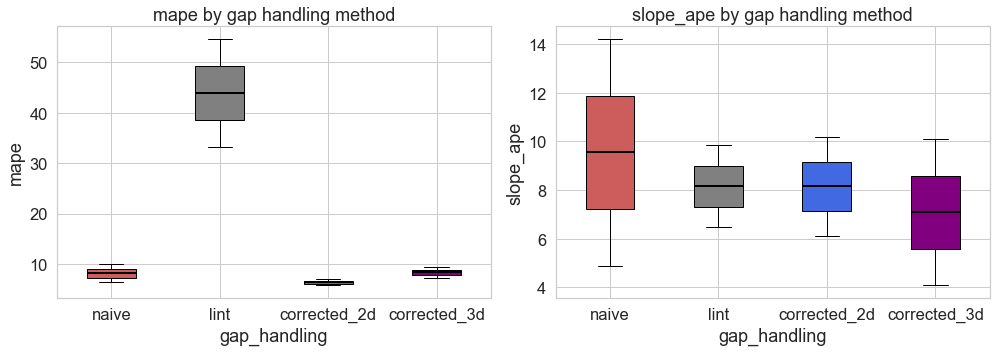

In [39]:
import matplotlib.pyplot as plt

# Assuming ints_copies_meta is your DataFrame
# Define the list of columns to plot
columns = ["mape", "slope_ape"]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Flatten the 2D array of axes for easy iteration
axes = axes.flatten()

custom_order = ["naive", "lint", "corrected_2d", "corrected_3d"]
colors = ['indianred', 'grey', 'royalblue', 'purple']

# Create boxplots for each column
for col, ax in zip(columns, axes):
    data_to_plot = [ints_copies_meta[ints_copies_meta['gap_handling'] == method][col] for method in custom_order]
    box = ax.boxplot(data_to_plot, patch_artist=True)
    
    # Set colors for the boxes
    
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    # Set colors for the median lines
    median_color = 'black'
    for median in box['medians']:
        median.set_color(median_color)
        median.set_linewidth(2)  # optional: set line width to make it more prominent

    ax.set_title(f'{col} by gap handling method')
    ax.set_xlabel('gap_handling')
    ax.set_ylabel(f'{col}')
    ax.set_xticklabels(custom_order)

# Adjust layout
plt.tight_layout()
plt.suptitle('')  # Remove the default title to avoid overlap
plt.show()


### 8b. Check final dataframes

Look at Jupyter variables to confirm what we've got 

## 9. Producing target plots

In [40]:
ints_copies_meta.head()

,int_index,file_index,int_start,int_end,slope_orig,version,missing_percent_overall,gap_handling,slope,slope_pe,slope_ape,mape
0,0,2,2016-01-03,2016-01-03 20:36:12.582,0.720494,0,45.55,naive,0.822931,14.217655,14.217655,6.368892
1,0,2,2016-01-03,2016-01-03 20:36:12.582,0.720494,0,45.55,lint,0.791379,9.838421,9.838421,33.238521
2,0,2,2016-01-03,2016-01-03 20:36:12.582,0.720494,1,55.68,naive,0.685329,-4.880726,4.880726,9.956912
3,0,2,2016-01-03,2016-01-03 20:36:12.582,0.720494,1,55.68,lint,0.673903,-6.466526,6.466526,54.714382
0,0,2,2016-01-03,2016-01-03 20:36:12.582,0.720494,0,45.55,corrected_2d,0.764586,6.119679,6.119679,5.717397


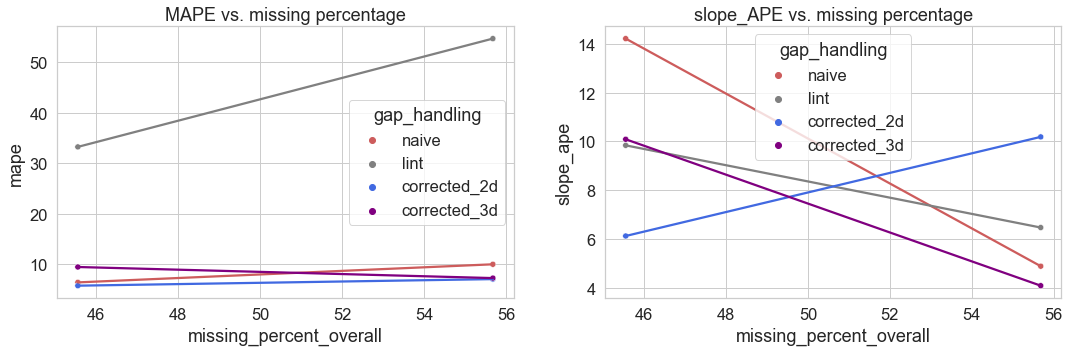

In [41]:
# Make scatterplot of mape vs. missing_percent, coloured by gap handling
palette = dict(zip(custom_order, colors))

# Plotting the MAPE vs. missing percentage
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
sns.scatterplot(data=ints_copies_meta, x="missing_percent_overall", y="mape", hue="gap_handling", palette=palette, ax = ax[0])
# Add regression lines
ax[0].set_title("MAPE vs. missing percentage")

# Add regression lines for each group
unique_gap_handling = ints_copies_meta['gap_handling'].unique()

for gap_handling_method in unique_gap_handling:
    subset = ints_copies_meta[ints_copies_meta['gap_handling'] == gap_handling_method]
    sns.regplot(data=subset, x="missing_percent_overall", y="mape", scatter=False, 
                color=palette[gap_handling_method], label=gap_handling_method, ci=None, ax = ax[0])

sns.scatterplot(data=ints_copies_meta, x="missing_percent_overall", y="slope_ape", hue="gap_handling", palette=palette, ax = ax[1])
# Add regression lines
ax[1].set_title("slope_APE vs. missing percentage")

# Add regression lines for each group
unique_gap_handling = ints_copies_meta['gap_handling'].unique()

for gap_handling_method in unique_gap_handling:
    subset = ints_copies_meta[ints_copies_meta['gap_handling'] == gap_handling_method]
    sns.regplot(data=subset, x="missing_percent_overall", y="slope_ape", scatter=False, 
                color=palette[gap_handling_method], label=gap_handling_method, ci=None, ax = ax[1])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


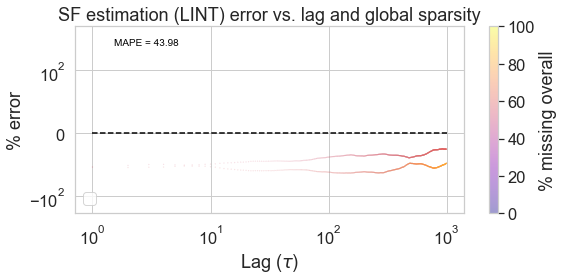

In [42]:
sf.plot_error_trend_line(sfs_copies_small[sfs_copies_small["gap_handling"]=="lint"], estimator="sf_2", title = "SF estimation (LINT) error vs. lag and global sparsity", y_axis_log=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


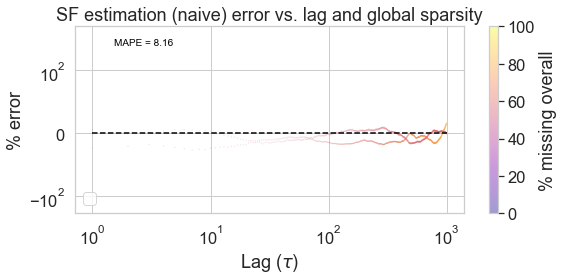

In [43]:
sf.plot_error_trend_line(sfs_copies_small[sfs_copies_small["gap_handling"]=="naive"], estimator="sf_2", title = "SF estimation (naive) error vs. lag and global sparsity", y_axis_log=True)

In [ ]:
# Annotate each heatmap trace with info
def annotate_curve(ax, x, y, text, offset_scaling=(0.3, 0.1)):
    # Find the index of y value closest to the median value
    idx = np.argmin(np.abs(y - np.percentile(y, 20)))

    # Coordinates of the point of maximum y value
    x_max = x[idx]
    y_max = y[idx]

    # Convert offset from axes fraction to data coordinates
    x_text = 10 ** (offset_scaling[0] * np.log10(x_max))  # Log-axis
    y_text = y_max + offset_scaling[1] * (ax.get_ylim()[1] - ax.get_ylim()[0])

    # Annotate with the text, adjusting the position with xytext_offset
    ax.annotate(
        text,
        xy=(x_max, y_max - 1),
        xytext=(x_text, y_text),
        # xycoords="axes fraction",
        # textcoords="axes fraction",
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"),
        bbox=dict(facecolor="white", edgecolor="white", boxstyle="round", alpha=0.7),
    )

   missing_percent_overall  gap_handling       mape  slope_pe
0                    45.55          none   9.976899  3.429146
1                    45.55          lint  35.445569  5.239747
0                    45.55  corrected_2d  19.709140  7.705153
1                    45.55  corrected_3d   9.437230 -7.675801
   missing_percent_overall  gap_handling       mape   slope_pe
2                    55.68          none  53.621609 -19.968509
3                    55.68          lint  72.353682 -16.613049
2                    55.68  corrected_2d  19.274762 -14.147643
3                    55.68  corrected_3d  12.618582  19.320287


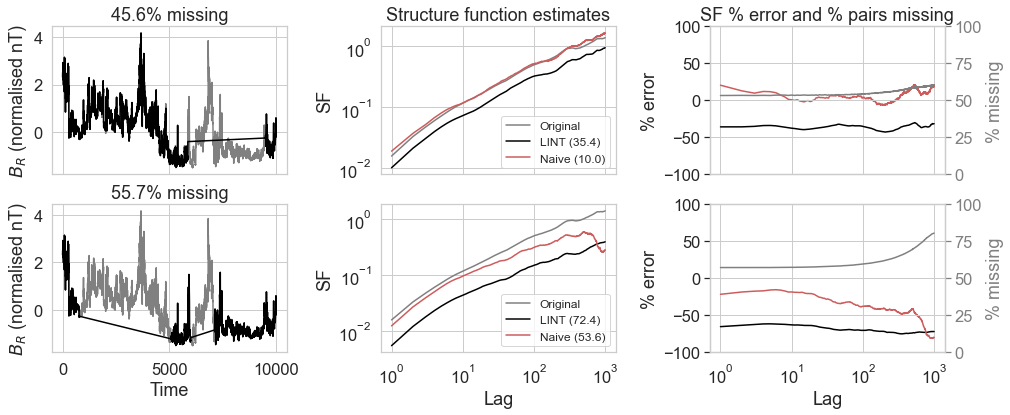

In [ ]:
int_index=0
num_version_to_plot = 2

fig, ax = plt.subplots(num_version_to_plot, 3, figsize=(16, num_version_to_plot*3))

for version in range(num_version_to_plot):
    ax[version, 0].plot(ints[int_index].values, c = "grey")
    ax[version, 0].plot(
        ints_copies.loc[(ints_copies["int_index"]==int_index) & 
                        (ints_copies["version"]==version) & 
                        (ints_copies["gap_handling"]=="lint"), "B_R"].values, c="black")

    # Put missing_percent_overall in the title
    ax[version, 0].set_title(f"{ints_copies_meta.loc[(ints_copies_meta['int_index']==int_index) & (ints_copies_meta['version']==version) & (ints_copies_meta['gap_handling']=='lint'), 'missing_percent_overall'].values[0]:.1f}% missing")

    # Plot the SF
    ax[version, 1].plot(
        sfs.loc[(sfs["int_index"]==int_index), "lag"],
        sfs.loc[(sfs["int_index"]==int_index), "sf_2"], c="grey", label = "Original")

    ax[version, 1].plot(
        sfs_copies.loc[(sfs_copies["int_index"]==int_index) & 
                        (sfs_copies["version"]==version) & 
                        (sfs_copies["gap_handling"]=="lint"), "lag"], 
        sfs_copies.loc[(sfs_copies["int_index"]==int_index) & 
                        (sfs_copies["version"]==version) & 
                        (sfs_copies["gap_handling"]=="lint"), "sf_2"], c="black", 
                        label="LINT ({:.1f})".format(ints_copies_meta.loc[(ints_copies_meta["int_index"]==int_index) &
                                                                (ints_copies_meta["version"]==version) &
                                                                (ints_copies_meta["gap_handling"]=="lint"), "mape"].values[0]),)
    ax[version, 1].plot(
        sfs_copies.loc[(sfs_copies["int_index"]==int_index) & 
                        (sfs_copies["version"]==version) & 
                        (sfs_copies["gap_handling"]=="naive"), "lag"], 
        sfs_copies.loc[(sfs_copies["int_index"]==int_index) & 
                        (sfs_copies["version"]==version) & 
                        (sfs_copies["gap_handling"]=="naive"), "sf_2"], c="indianred",
                        label="Naive ({:.1f})".format(ints_copies_meta.loc[(ints_copies_meta["int_index"]==int_index) &
                                        (ints_copies_meta["version"]==version) &
                                        (ints_copies_meta["gap_handling"]=="naive"), "mape"].values[0]),)
    
    # Plot the sf_2_pe
    ax[version, 2].plot(
        sfs_copies.loc[(sfs_copies["int_index"]==int_index) & 
                        (sfs_copies["version"]==version) & 
                        (sfs_copies["gap_handling"]=="lint"), "lag"], 
        sfs_copies.loc[(sfs_copies["int_index"]==int_index) & 
                        (sfs_copies["version"]==version) & 
                        (sfs_copies["gap_handling"]=="lint"), "sf_2_pe"], c="black")
    ax[version, 2].plot(
        sfs_copies.loc[(sfs_copies["int_index"]==int_index) & 
                        (sfs_copies["version"]==version) & 
                        (sfs_copies["gap_handling"]=="naive"), "lag"], 
        sfs_copies.loc[(sfs_copies["int_index"]==int_index) & 
                        (sfs_copies["version"]==version) & 
                        (sfs_copies["gap_handling"]=="naive"), "sf_2_pe"], c="indianred")
    
    # plot sample size n on right axis
    ax2 = ax[version, 2].twinx()
    ax2.plot(
        sfs_copies.loc[(sfs_copies["int_index"]==int_index) & 
                        (sfs_copies["version"]==version) & 
                        (sfs_copies["gap_handling"]=="naive"), "lag"], 
        sfs_copies.loc[(sfs_copies["int_index"]==int_index) & 
                        (sfs_copies["version"]==version) & 
                        (sfs_copies["gap_handling"]=="naive"), "missing_percent"], c="grey")

    # Label the axes
    ax[1, 0].set_xlabel("Time")
    ax[version, 0].set_ylabel("$B_R$ (normalised nT)")
    ax[1, 1].set_xlabel("Lag")
    ax[version, 1].set_ylabel("SF")
    ax[1, 2].set_xlabel("Lag")
    ax[version, 2].set_ylabel("% error")
    ax2.set_ylabel("% missing", color="grey")
    ax2.tick_params(axis="y", colors="grey")
    ax2.set_ylim(0,100)

    #ax[version, 2].axhline(0, c="black", linestyle="--")
    ax[version, 2].set_ylim(-100, 100)

    ax[version, 1].set_xscale("log")
    ax[version, 1].set_yscale("log")
    ax[version, 2].set_xscale("log")
    ax[version, 1].legend(fontsize=12)
    [ax[0, i].set_xticklabels([]) for i in range(3)]

    print(ints_copies_meta.loc[(ints_copies_meta["int_index"]==int_index) & (ints_copies_meta["version"]==version)][["missing_percent_overall", "gap_handling", "mape", "slope_pe"]])


# Add titles
ax[0, 1].set_title("Structure function estimates")
ax[0, 2].set_title("SF % error and % pairs missing")
plt.subplots_adjust(wspace=0.4)


In [ ]:
# Annotate each heatmap trace with info
def annotate_curve(ax, x, y, text, offset_scaling=(0.3, 0.1)):
    # Find the index of y value closest to the median value
    idx = np.argmin(np.abs(y - np.percentile(y, 20)))

    # Coordinates of the point of maximum y value
    x_max = x.iloc[idx]
    y_max = y.iloc[idx]

    # Convert offset from axes fraction to data coordinates
    x_text = 10 ** (offset_scaling[0] * np.log10(x_max))  # Log-axis
    y_text = y_max + offset_scaling[1] * (ax.get_ylim()[1] - ax.get_ylim()[0])

    # Annotate with the text, adjusting the position with xytext_offset
    ax.annotate(
        text,
        xy=(x_max, y_max - 1),
        xytext=(x_text, y_text),
        # xycoords="axes fraction",
        # textcoords="axes fraction",
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"),
        bbox=dict(facecolor="white", edgecolor="white", boxstyle="round", alpha=0.7),
    )

   missing_percent_overall  gap_handling       mape  slope_pe
0                    45.55          none   9.976899  3.429146
1                    45.55          lint  35.445569  5.239747
0                    45.55  corrected_2d  19.709140  7.705153
1                    45.55  corrected_3d   9.437230 -7.675801
   missing_percent_overall  gap_handling       mape   slope_pe
2                    55.68          none  53.621609 -19.968509
3                    55.68          lint  72.353682 -16.613049
2                    55.68  corrected_2d  19.274762 -14.147643
3                    55.68  corrected_3d  12.618582  19.320287


(0.0, 100.0)

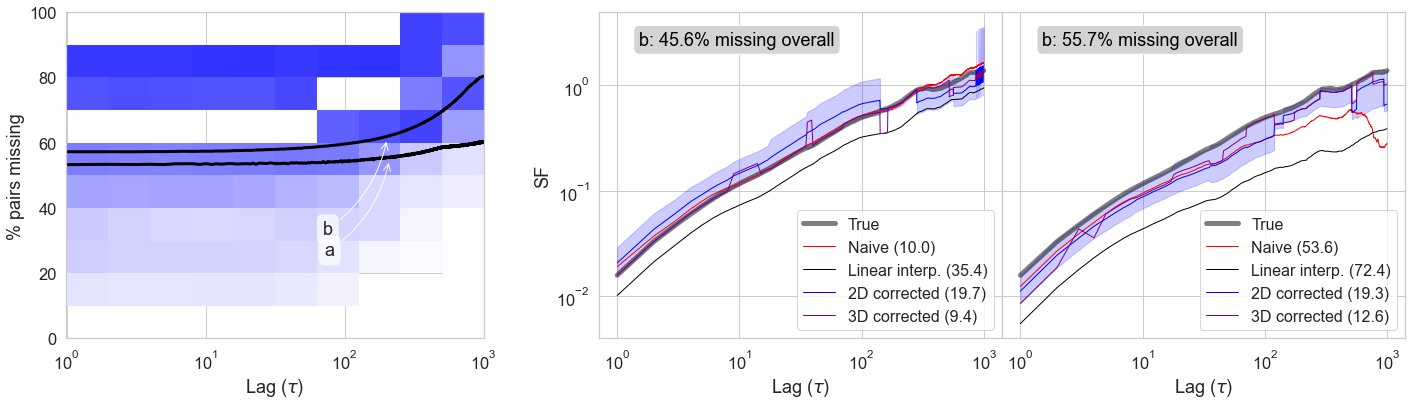

In [ ]:
fig = plt.figure(figsize=(20, 6))

# Create a GridSpec layout with specified width ratios and horizontal space
gs1 = GridSpec(1, 1, left=0.06, right=0.35)
gs2 = GridSpec(1, 2, left=0.43, right=0.99, wspace=0)

# Create subplots
ax0 = fig.add_subplot(gs1[0, 0])
ax1 = fig.add_subplot(gs2[0, 0])

for version in range(2):

    if version == 0:
        ax = ax1
        ax.set_ylabel("SF")
    else:
        ax = fig.add_subplot(gs2[0, version], sharey=ax1)
        plt.setp(ax.get_yticklabels(), visible=False)
        
    ax.plot(
        sfs[sfs["int_index"]==int_index]["lag"],
        sfs[sfs["int_index"]==int_index]["sf_2"],
        color="black",
        label="True",
        lw=5,
        alpha=0.5,
    )
    ax.plot(
        sfs_copies_small.loc[(sfs_copies_small["int_index"]==int_index) & (sfs_copies_small["version"]==version) & 
                                                                        (sfs_copies_small["gap_handling"]=="naive"), "lag"],
        sfs_copies_small.loc[(sfs_copies_small["int_index"]==int_index) & (sfs_copies_small["version"]==version) & 
                                                                        (sfs_copies_small["gap_handling"]=="naive"), "sf_2"],
        color="red",
        lw=1,
        label="Naive ({:.1f})".format(ints_copies_meta.loc[(ints_copies_meta["int_index"]==int_index) &
                                                                (ints_copies_meta["version"]==version) &
                                                                (ints_copies_meta["gap_handling"]=="naive"), "mape"].values[0]),
    )
    ax.plot(
        sfs_copies_small.loc[(sfs_copies_small["int_index"]==int_index) & (sfs_copies_small["version"]==version) & 
                                                                        (sfs_copies_small["gap_handling"]=="lint"), "lag"],
        sfs_copies_small.loc[(sfs_copies_small["int_index"]==int_index) & (sfs_copies_small["version"]==version) & 
                                                                        (sfs_copies_small["gap_handling"]=="lint"), "sf_2"],
        color="black",
        lw=1,
        label="Linear interp. ({:.1f})".format(ints_copies_meta.loc[(ints_copies_meta["int_index"]==int_index) &
                                                                (ints_copies_meta["version"]==version) &
                                                                (ints_copies_meta["gap_handling"]=="lint"), "mape"].values[0]),
    )
    ax.plot(
        sfs_copies_small.loc[(sfs_copies_small["int_index"]==int_index) & (sfs_copies_small["version"]==version) & 
                                                                        (sfs_copies_small["gap_handling"]=="corrected_2d"), "lag"],
        sfs_copies_small.loc[(sfs_copies_small["int_index"]==int_index) & (sfs_copies_small["version"]==version) & 
                                                                        (sfs_copies_small["gap_handling"]=="corrected_2d"), "sf_2"],
        color="blue",
        lw=1,
        label="2D corrected ({:.1f})".format(ints_copies_meta.loc[(ints_copies_meta["int_index"]==int_index) &
                                                                (ints_copies_meta["version"]==version) &
                                                                (ints_copies_meta["gap_handling"]=="corrected_2d"), "mape"].values[0]),
    )
    ax.plot(
        sfs_copies_small.loc[(sfs_copies_small["int_index"]==int_index) & (sfs_copies_small["version"]==version) & 
                                                                        (sfs_copies_small["gap_handling"]=="corrected_3d"), "lag"],
        sfs_copies_small.loc[(sfs_copies_small["int_index"]==int_index) & (sfs_copies_small["version"]==version) & 
                                                                        (sfs_copies_small["gap_handling"]=="corrected_3d"), "sf_2"],
        color="purple",
        lw=1,
        label="3D corrected ({:.1f})".format(ints_copies_meta.loc[(ints_copies_meta["int_index"]==int_index) &
                                                                (ints_copies_meta["version"]==version) &
                                                                (ints_copies_meta["gap_handling"]=="corrected_3d"), "mape"].values[0]),
    )
    ax.fill_between(
        sfs_copies_small.loc[(sfs_copies_small["int_index"]==int_index) & (sfs_copies_small["version"]==version) & 
                                                                        (sfs_copies_small["gap_handling"]=="corrected_3d"), "lag"],
        sfs_copies_small.loc[(sfs_copies_small["int_index"]==int_index) & (sfs_copies_small["version"]==version) & 
                                                                        (sfs_copies_small["gap_handling"]=="corrected_2d"), "sf_2_lower"],
            sfs_copies_small.loc[(sfs_copies_small["int_index"]==int_index) & (sfs_copies_small["version"]==version) & 
                                                                        (sfs_copies_small["gap_handling"]=="corrected_2d"), "sf_2_upper"],
        color="blue",
        alpha=0.2,
    )

    missing = ints_copies_meta.loc[
        (ints_copies_meta["int_index"] == int_index) & (ints_copies_meta["version"] == version),
        "missing_percent_overall"
    ].values

    ax.legend(loc="lower right", fontsize = 16)
    ax.semilogx()
    ax.semilogy()


    # PLOTTING HEATMAP IN FIRST PANEL

    c = ax0.pcolormesh(
        heatmap_bin_edges_2d[0],
        heatmap_bin_edges_2d[1],  # convert to % Missing
        heatmap_bin_vals_2d.T,
        cmap="bwr",
    )
    # fig.colorbar(c, ax=ax0, label="MPE")
    c.set_clim(-100, 100)
    c.set_facecolor("black")
    # ax0.set_xlabel("Lag")
    ax0.plot(
        sfs_copies_small.loc[(sfs_copies_small["int_index"]==int_index) & (sfs_copies_small["version"]==version) & 
                                                                        (sfs_copies_small["gap_handling"]=="corrected_3d"), "lag"],
        sfs_copies_small.loc[(sfs_copies_small["int_index"]==int_index) & (sfs_copies_small["version"]==version) & 
                                                                        (sfs_copies_small["gap_handling"]=="corrected_3d"), "missing_percent"],
        c="black",
        lw=3,
    )
    alphabet = "abcdefghijklmnopqrstuvwxyz"
    annotate_curve(
        ax0,
        sfs_copies_small.loc[(sfs_copies_small["int_index"]==int_index) & (sfs_copies_small["version"]==version) & 
                                                                        (sfs_copies_small["gap_handling"]=="lint"), "lag"],
        sfs_copies_small.loc[(sfs_copies_small["int_index"]==int_index) & (sfs_copies_small["version"]==version) & 
                                                                        (sfs_copies_small["gap_handling"]=="lint"), "missing_percent"],
        f"{alphabet[version]}",
        offset_scaling=(0.8, -0.3),
    )

    ax.annotate(
        f"{alphabet[i]}: {float(missing[0]):.1f}% missing overall",
        xy=(1, 1),
        xycoords="axes fraction",
        xytext=(0.1, 0.9),
        textcoords="axes fraction",
        transform=ax.transAxes,
        c="black",
        fontsize=18,
        bbox=dict(facecolor="lightgrey", edgecolor="white", boxstyle="round"),
    )


    ax.set_xlabel("Lag ($\\tau$)")

    print(ints_copies_meta.loc[(ints_copies_meta["int_index"]==int_index) & (ints_copies_meta["version"]==version)][["missing_percent_overall", "gap_handling", "mape", "slope_pe"]])

    
ax0.set_xscale("log")
ax0.set_xlabel("Lag ($\\tau$)")
ax0.set_ylabel("% pairs missing")
ax0.set_ylim(0, 100)

## 10. Running for multiple files and with training and test splits

Make it very clear how many files, intervals, repetitions I have